In [123]:
%pip install networkx
%pip install matplotlib
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [124]:
df = pd.read_excel('data/aml_smurfing_structuring.xlsx')
df = df[df['direction'] == 'credit']
df.head()

entry_id            timestamp    account_id  counterparty   amount  \
1  c86bee4976d8-C  2025-01-20 07:27:17  74268713-f55  ca92b7e6-b7b  3085.63   
3  afa1fccc57f9-C  2025-01-25 00:46:41  316af9f4-aaf  20a1eeb2-cd7  4136.00   
4  e6b7194eb690-C  2025-01-29 15:48:05  0fe7ca38-8f8           ATM  3751.10   
5  920a4d242860-C  2025-01-15 11:47:37  bf25e748-d11  5585dc1b-1e2  4855.61   
7  8883d36d9c23-C  2025-01-17 13:47:06  bfb2c380-250  7a39698b-9b8  2946.06   

  direction currency payment_type  is_laundering  \
1    credit      USD        Check          False   
3    credit      USD         Wire          False   
4    credit      USD         Cash          False   
5    credit      USD         Wire          False   
7    credit      USD        Check          False   

                                  source_description    atm_id  \
1                                  CHECK - Black Inc       NaN   
3                             WIRE - Heather Cordova       NaN   
4  CASH - Deposit at Cole LLC ATM (73622 Jerry Vi...  29d7313d   
5                                 WIRE - John Willis       NaN   
7                            CHECK - Robertson Group       NaN   

                                        atm_location  
1                                                NaN  
3                                                NaN  
4  73622 Jerry Ville Suite 819, East Williamton, ...  
5                                                NaN  
7                                                NaN

In [125]:
G = nx.DiGraph()

for _, row in df.iterrows():
    src = row['account_id']
    tgt = row['counterparty']
    amt = row['amount']
    laundering = row['is_laundering']
    G.add_edge(src, tgt, amount=amt, money_laundering=laundering)

In [126]:
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")

laundering_edges = sum(1 for _, _, d in G.edges(data=True) if d.get('money_laundering', False))

print(f"Laundering transactions: {laundering_edges}")


Total nodes: 221
Total edges: 513
Laundering transactions: 195


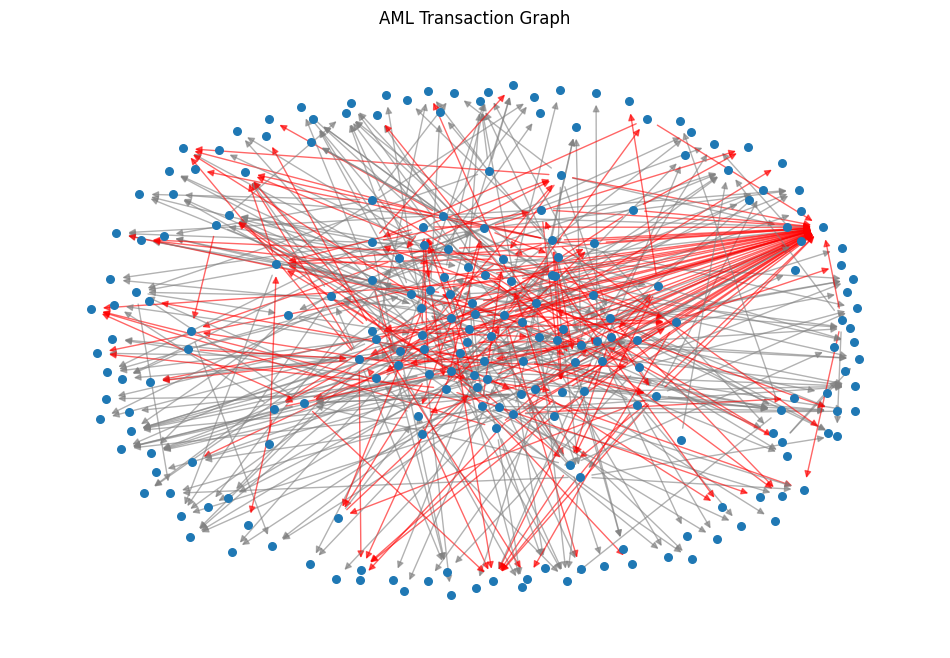

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Use spring layout for basic visualization
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Color laundering edges red
edge_colors = ['red' if d['money_laundering'] else 'gray' for _, _, d in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos, node_size=30)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, alpha=0.6)
plt.title("AML Transaction Graph")
plt.axis('off')
plt.show()


In [128]:
# Step 1: Extract laundering edges only
laundering_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('money_laundering', False)]

# Step 2: Create a subgraph with those edges
G_laundering = G.edge_subgraph(laundering_edges).copy()

print(f"Laundering subgraph — Nodes: {G_laundering.number_of_nodes()}, Edges: {G_laundering.number_of_edges()}")


Laundering subgraph — Nodes: 122, Edges: 195


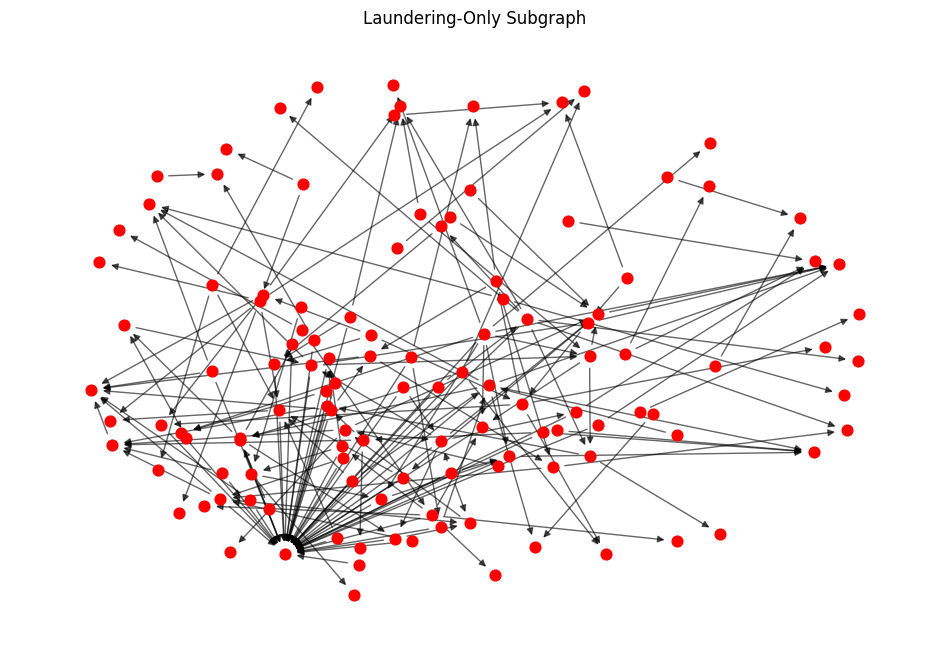

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_laundering, k=0.4)

nx.draw_networkx_nodes(G_laundering, pos, node_color='red', node_size=60)
nx.draw_networkx_edges(G_laundering, pos, edge_color='black', arrows=True, alpha=0.6)

plt.title("Laundering-Only Subgraph")
plt.axis('off')
plt.show()


In [130]:
from collections import defaultdict
import networkx as nx

# Step 1: Aggregate laundering transactions by (source, target)
edge_aggregates = defaultdict(lambda: {"amount": 0, "laundering": False})

for _, row in df[df["is_laundering"] == True].iterrows():
    key = (row["account_id"], row["counterparty"])
    edge_aggregates[key]["amount"] += row["amount"]
    edge_aggregates[key]["laundering"] = True  # All transactions are laundering here

# Step 2: Build weighted graph
G_laundering_weighted = nx.DiGraph()

for (src, tgt), attrs in edge_aggregates.items():
    G_laundering_weighted.add_edge(
        src, tgt,
        weight=attrs["amount"],
        is_laundering=attrs["laundering"]
    )


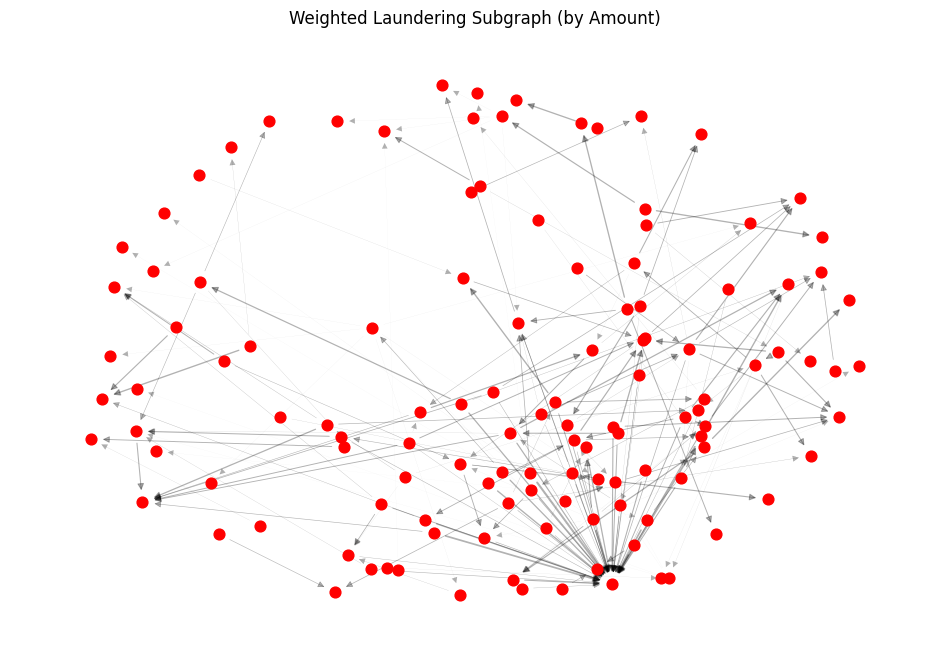

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_laundering_weighted, k = 5)

# Scale edge width by weight
weights = [d['weight'] / 5000 for _, _, d in G_laundering_weighted.edges(data=True)]  # adjust divisor to scale nicely

nx.draw_networkx_nodes(G_laundering_weighted, pos, node_color='red', node_size=60)
nx.draw_networkx_edges(
    G_laundering_weighted, pos,
    width=weights,
    edge_color='black',
    arrows=True,
    alpha=0.3
)

plt.title("Weighted Laundering Subgraph (by Amount)")
plt.axis('off')
plt.show()


Lets identify the smurfs and collectors first from the known launderers.

Smurfs will have large amounts of cash deposits, especially just under the $10k threshold. And they will have large transfers throughout the network. Many of the deposits will also be in a short time window and will move quickly out of the accounts.

In [132]:
def is_high_cash_depositor(entity_id, df, min_txns=3, min_total=10000):
    deposits = df[(df['account_id'] == entity_id) & (df['source_description'].str.contains('cash deposit', case=False, na=False))]
    return len(deposits) >= min_txns and deposits['amount'].sum() >= min_total


In [133]:
def is_distributor(entity_id, df, min_receivers=3):
    outgoing = df[df['account_id'] == entity_id]
    return outgoing['counterparty'].nunique() >= min_receivers


In [134]:
def is_structuring_pattern(df, threshold=10000, margin=200):
    return df['amount'].between(threshold - margin, threshold).sum() > 0


In [135]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

likely_collectors = [n for n in G.nodes if in_degrees[n] > 5 and out_degrees[n] == 0]


In [136]:
smurf_score = {}

for node in G.nodes:
    score = 0
    if is_high_cash_depositor(node, df): score += 1
    if is_distributor(node, df): score += 1
    if is_structuring_pattern(df): score += 1
    smurf_score[node] = score

likely_smurfs = [node for node, score in smurf_score.items() if score >= 1]


In [137]:
node_colors = []
node_sizes = []
node_labels = {}

for node in G.nodes:
    if node in likely_smurfs:
        node_colors.append('blue')
        node_sizes.append(100)
    elif node in likely_collectors:
        node_colors.append('red')
        node_sizes.append(600)
    else:
        node_colors.append('black')
        node_sizes.append(30)
    node_labels[node] = node

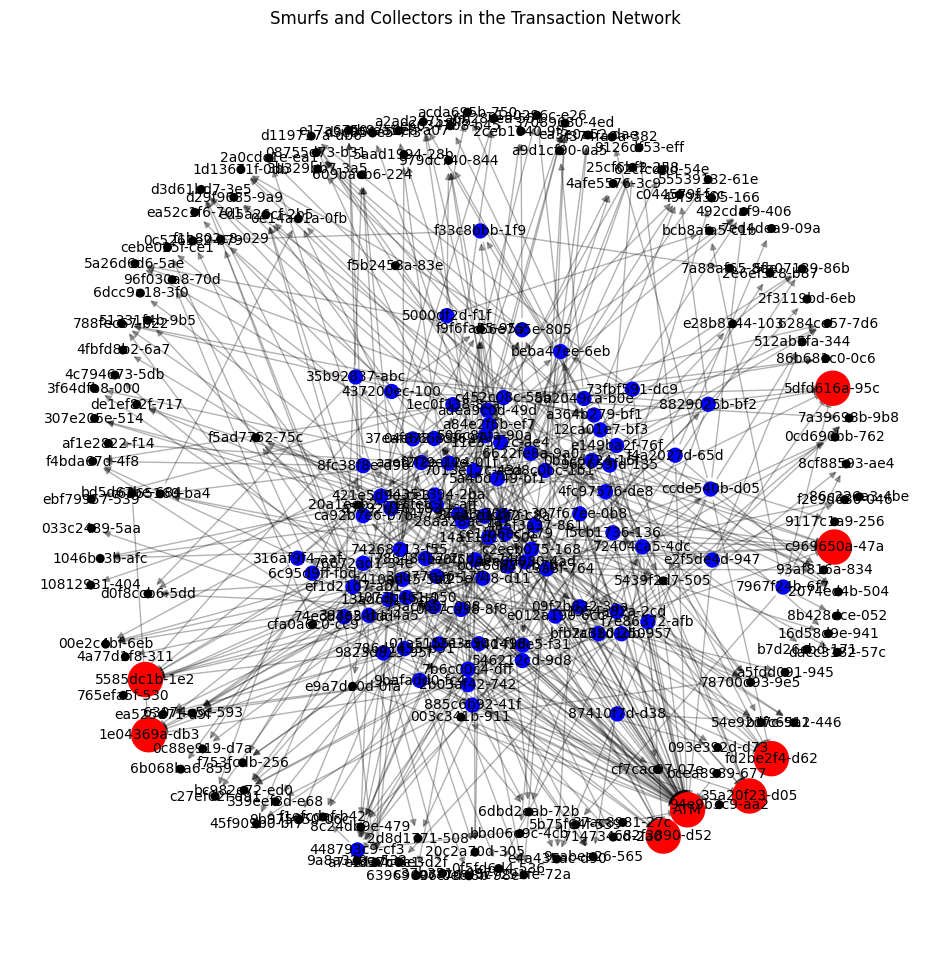

In [138]:

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw the network
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, alpha=0.3, arrows=True, width=1)

# Draw labels for smurfs and collectors
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

plt.title("Smurfs and Collectors in the Transaction Network")
plt.axis('off')
plt.show()


In [139]:
import math
smurfs = list(likely_smurfs)
collectors = list(likely_collectors)
others = [n for n in G.nodes if n not in smurfs and n not in collectors]

def circular_shell_layout(groups, center=(0, 0), radius_step=2.5):
    layout = {}
    for i, group in enumerate(groups):
        radius = (i + 1) * radius_step
        angle_step = 2 * math.pi / len(group) if group else 1
        for j, node in enumerate(group):
            angle = j * angle_step
            x = center[0] + radius * math.cos(angle)
            y = center[1] + radius * math.sin(angle)
            layout[node] = (x, y)
    return layout

# Define the order: collectors (inner), others (middle), smurfs (outer)
pos = circular_shell_layout([collectors, others, smurfs])


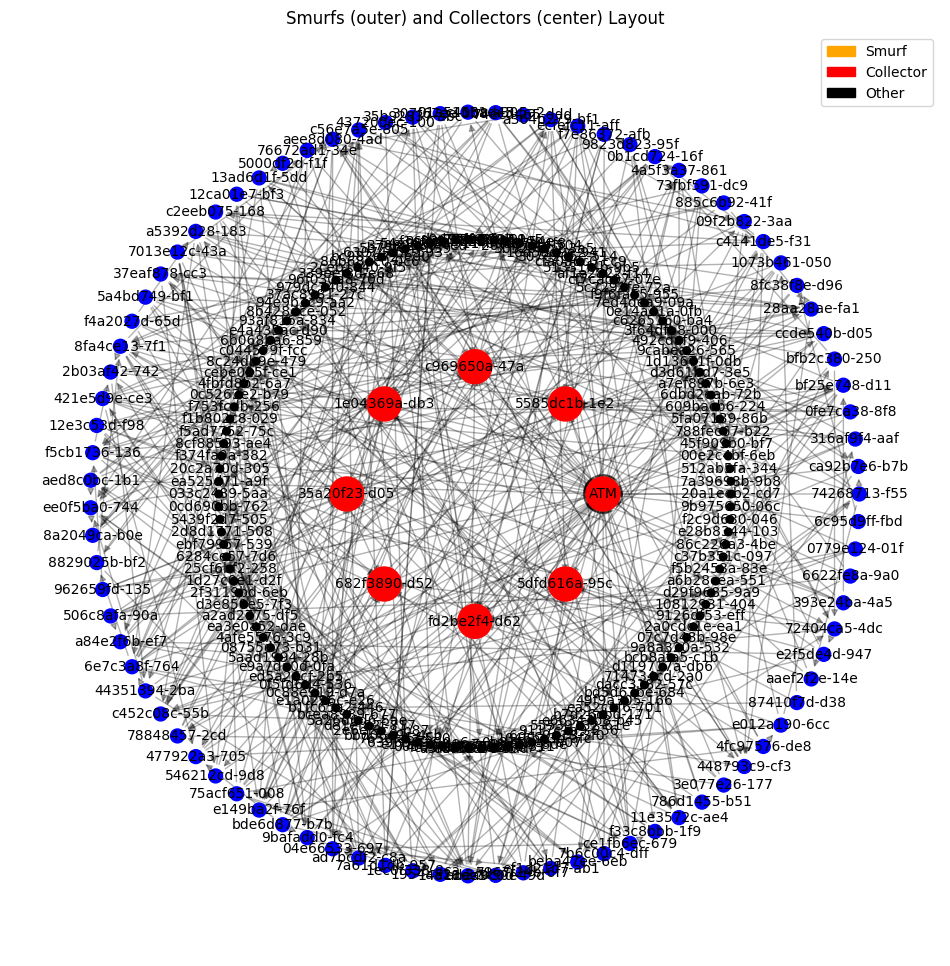

In [140]:
plt.figure(figsize=(12, 12))

# Use previously defined color, size, label settings
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, alpha=0.3, arrows=True)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

# Optional: add legend
import matplotlib.patches as mpatches
plt.legend(handles=[
    mpatches.Patch(color='orange', label='Smurf'),
    mpatches.Patch(color='red', label='Collector'),
    mpatches.Patch(color='black', label='Other'),
])
plt.title("Smurfs (outer) and Collectors (center) Layout")
plt.axis('off')
plt.show()


In [141]:
print(len(G.nodes), len(likely_smurfs), len(likely_collectors))

laundering_rows = df[df['is_laundering'] == True]
print(len(laundering_rows['account_id'].unique()))

#Get a count of how many smurfs and collectors are contained in laundering transactions
smurf_count = len(set(laundering_rows['account_id']).intersection(likely_smurfs))
collector_count = len(set(laundering_rows['counterparty']).intersection(likely_collectors))
print(f"Smurfs in laundering transactions: {smurf_count}")
print(f"Collectors in laundering transactions: {collector_count}")


221 87 8
85
Smurfs in laundering transactions: 78
Collectors in laundering transactions: 4


In [142]:
# 1. Filter for transactions where sender is a smurf
smurf_txns = df[df['account_id'].isin(smurfs)]

# 2. Aggregate amounts received per receiver
collector_candidates = (
    smurf_txns.groupby('counterparty')['amount']
    .sum()
    .reset_index()
)

# 3. Filter for total > $10,000
confirmed_collectors = collector_candidates[collector_candidates['amount'] > 10000]

# 4. Extract list of collector IDs
collectors = confirmed_collectors['counterparty'].tolist()


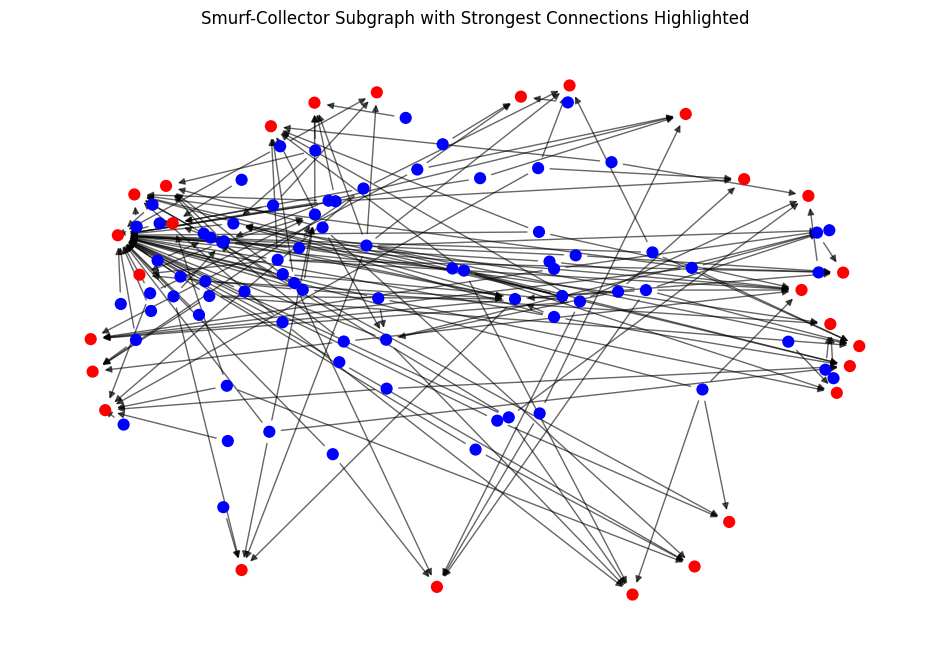

In [145]:
# Step 1: Filter the graph to include only edges between smurfs and collectors
edges_between_smurfs_and_collectors = [
    (u, v, d) for u, v, d in G.edges(data=True)
    if u in likely_smurfs and v in collectors
]
smurf_collector_subgraph = G.edge_subgraph(
    [(u, v) for u, v, _ in edges_between_smurfs_and_collectors]
).copy()

# Step 2: Sort edges by aggregate amount (weight) in descending order
sorted_edges = sorted(
    smurf_collector_subgraph.edges(data=True),
    key=lambda edge: edge[2].get('weight', 0),
    reverse=True
)

# Step 3: Create a new layout where smurfs are positioned closer to their strongest collector connections
pos = nx.spring_layout(smurf_collector_subgraph, k=0.4)

# Adjust positions for smurfs based on their strongest connections
for smurf, collector, data in sorted_edges:
    if smurf in likely_smurfs and collector in collectors:
        pos[smurf] = pos[collector] + (pos[smurf] - pos[collector]) * 0.5  # Move smurf closer to collector

# Step 4: Update node colors
node_colors = []
for node in smurf_collector_subgraph.nodes:
    if node in likely_smurfs:
        node_colors.append('blue')  # Smurfs are blue
    elif node in collectors:
        node_colors.append('red')  # Collectors are red
    else:
        node_colors.append('black')  # Others are black

# Step 5: Plot the graph
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(smurf_collector_subgraph, pos, node_color=node_colors, node_size=60)
nx.draw_networkx_edges(smurf_collector_subgraph, pos, edge_color='black', arrows=True, alpha=0.6)
plt.title("Smurf-Collector Subgraph with Strongest Connections Highlighted")
plt.axis('off')
plt.show()


In [146]:
# Calculate betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(G)

# Find the node with the highest betweenness centrality
most_disruptive_node = max(betweenness_centrality, key=betweenness_centrality.get)
highest_centrality = betweenness_centrality[most_disruptive_node]

print(f"The most disruptive node to remove is: {most_disruptive_node}")
print(f"Betweenness centrality of this node: {highest_centrality}")

The most disruptive node to remove is: 546212cd-9d8
Betweenness centrality of this node: 0.05470077487200778
